In [1]:
from fastai.tabular.all import *

## Preprocessamento dos dados

In [2]:
def load(file_path):
  df = pd.read_csv(file_path)
  m, s = df['tow'].mean(), df['tow'].std()
  df['date'] = pd.to_datetime(df['date'])
  df['actual_offblock_time'] = pd.to_datetime(df['actual_offblock_time'])
  df['arrival_time'] = pd.to_datetime(df['arrival_time'])
  df['offblock_hour'] = df['actual_offblock_time'].dt.round('H').dt.hour
  df['offblock_day_of_week'] = df['actual_offblock_time'].dt.dayofweek
  df['offblock_month'] = df['actual_offblock_time'].dt.month
  df = df.drop(columns=['flight_id','name_adep', 'callsign', 'actual_offblock_time', 'arrival_time', 'date'])
  df['tow'] = (df['tow']-m)/s
  return df, m, s # Roubando aqui na média e desvio padrão do dataset inteiro :p

df, mean, std = load('challenge_set.csv')
df.head()

,adep,country_code_adep,ades,name_ades,country_code_ades,aircraft_type,wtc,airline,flight_duration,taxiout_time,flown_distance,tow,offblock_hour,offblock_day_of_week,offblock_month
0,EGLL,GB,EICK,Cork,IE,A320,M,a73f82288988b79be490c6322f4c32ed,61,18,321,-0.464485,14,5,1
1,LEBL,ES,KMIA,Miami,US,B772,H,5543e4dc327359ffaf5b9c0e6faaf0e1,570,13,4193,1.989801,10,5,1
2,ESSA,SE,KORD,Chicago O'Hare,US,A333,H,8be5c854fd664bcb97fb543339f74770,554,15,3770,2.834012,10,5,1
3,LSZH,CH,KPHL,Philadelphia,US,B788,H,5543e4dc327359ffaf5b9c0e6faaf0e1,497,11,3607,1.467256,11,5,1
4,EIDW,IE,EGLL,London Heathrow,GB,A21N,M,a73f82288988b79be490c6322f4c32ed,55,14,305,-0.172087,13,5,1


## Modelo (com pre-processamento auto)

In [3]:
splits = RandomSplitter(valid_pct=0.2)(range_of(df))
to = TabularPandas(df, procs=[Categorify, FillMissing, Normalize],
                   cat_names = ['adep', 'country_code_adep', 'ades', 'name_ades', 'country_code_ades',
                                'aircraft_type', 'wtc', 'airline', 'offblock_hour', 'offblock_day_of_week', 'offblock_month'],
                   cont_names = ['flight_duration', 'taxiout_time', 'flown_distance'],
                   y_names='tow',
                   splits=splits)
dls = to.dataloaders(bs=64)

In [4]:
learn = tabular_learner(dls, metrics=accuracy)

In [5]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,0.031219,0.008544,0.000000,00:30
1,0.022229,0.007596,0.000000,00:30
2,0.023709,0.007106,0.000000,00:30
3,0.018542,0.007038,0.000000,00:29
4,0.024506,0.006357,0.000000,00:30
5,0.028802,0.014277,0.000000,00:31
6,0.020479,0.005707,0.000000,00:29
7,0.017463,0.006137,0.000000,00:30
8,0.018264,0.006704,0.000000,00:30
9,0.022283,0.004982,0.000000,00:31


## Validação

(tensor(-0.0021), tensor(0.0705))

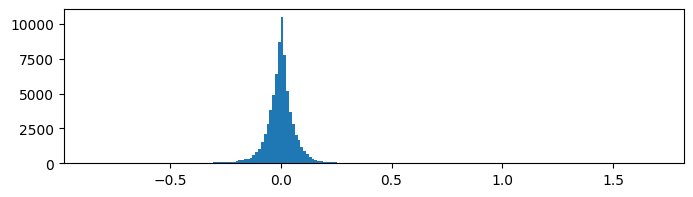

In [6]:
plt.figure(figsize=(8, 2))
preds_valida, real_valida = learn.get_preds()
diff_valida = preds_valida - real_valida
plt.hist(diff_valida.numpy(), bins=200)
diff_valida.mean(), diff_valida.std()

## Teste

In [7]:
df_test, _, _ = load('submission_set.csv')
dl_test = learn.dls.test_dl(df_test)
preds, _ = learn.get_preds(dl=dl_test)
valores = (preds*std+mean).numpy()

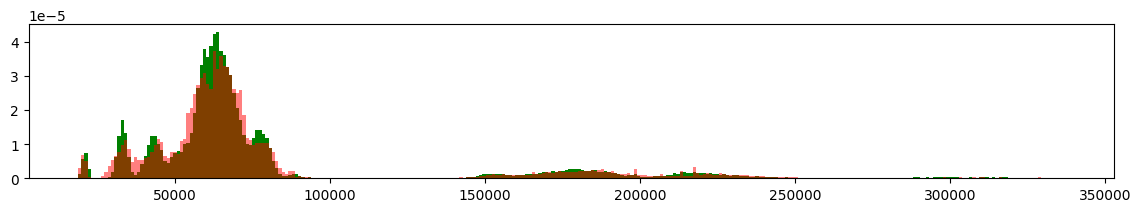

In [8]:
plt.figure(figsize=(14, 2))
nums, bins, f = plt.hist(valores, bins=300, density=True, color='g')
plt.hist(df['tow']*std+mean, bins=bins, alpha=0.5, color='r', density=True);

# Submissão

In [9]:
dft0 = pd.read_csv('submission_set.csv')
dft0['tow'] = valores
dft0[['flight_id', 'tow']].to_csv('mlp.csv', index=False)

In [10]:
!head mlp.csv

flight_id,tow
248753821,68915.91
248753822,213001.84
248754498,217307.66
248757623,66044.07
248763603,63943.03
248755068,61226.816
248754229,57157.43
248754894,57718.785
248754751,58821.902


In [11]:
# !mc cp ./mlp.csv dc24/submissions/team_tiny_rainbow_v2_7ec66710-1eb8-478e-8976-584c090b6373.csv